**Inference with the trained speech model and the trained vocoder model**

First change your directory to the one containing the TensorFlowTTS files and install the dependencies required to run the code.

In [ ]:
cd /content/drive/My Drive/projectFiles/TensorFlowTTS

In [ ]:
!pip install TensorFlowTTS

     |████████████████████████████████| 112kB 5.6MB/s 
     |████████████████████████████████| 320.4MB 39kB/s 
     |████████████████████████████████| 245kB 43.8MB/s 
     |████████████████████████████████| 225kB 47.3MB/s 
     |████████████████████████████████| 184kB 45.1MB/s 
     |████████████████████████████████| 1.3MB 40.8MB/s 
     |████████████████████████████████| 1.7MB 41.4MB/s 
     |████████████████████████████████| 3.1MB 37.9MB/s 
     |████████████████████████████████| 1.1MB 41.6MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 184kB 42.0MB/s 
  Created wheel for pyworld: filename=pyworld-0.2.12-cp36-cp36m-linux_x86_64.whl size=609445 sha256=35a39ba3e49ca882c42219b8258d9b2308b9117d90cee9a206c2ba4a2f98bc18
  Stored in directory: /root/.cache/pip/wheels/d0/e4/1c/a508000462b83164d5eba9a4b46f39b4b1645ac952bbe71551
  Created wheel for librosa: filename=librosa-0.8.0-cp36-none-any.whl size=201376 sha256=9cb1d80ad6dbc9bfd5098d6b12

**Load Model**

In [ ]:
import tensorflow as tf

import yaml
import numpy as np
import matplotlib.pyplot as plt

import IPython.display as ipd

from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import AutoProcessor

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Unzipping corpora/cmudict.zip.


**Load Tacotron-2 trained model from previous notebook**

In [ ]:
tacotron2_config = AutoConfig.from_pretrained('examples/tacotron2/conf/tacotron2.v1.yaml')
tacotron2 = TFAutoModel.from_pretrained(
    config=tacotron2_config,
    pretrained_path="/content/drive/My Drive/projectFiles/Final_Project_Main/TensorFlowTTS/examples/tacotron2/exp/train.tacotron2.v1/checkpoints/model-20000.h5",
    training=False, 
    name="tacotron2"
)

**Download and load the MelGAN vocoder**

In [ ]:
melgan_config = AutoConfig.from_pretrained('examples/melgan/conf/melgan.v1.yaml')
melgan = TFAutoModel.from_pretrained(
    config=melgan_config,
    pretrained_path="melgan-1M6.h5",
    name="melgan"
)

**Download and load the processor for LJ Speech database**

In [ ]:
processor = AutoProcessor.from_pretrained(pretrained_path="./ljspeech_mapper.json")

**Inference**

In [ ]:
def do_synthesis(input_text, text2mel_model, vocoder_model, text2mel_name, vocoder_name):
  input_ids = processor.text_to_sequence(input_text)

  # text2mel part
  if text2mel_name == "TACOTRON":
    _, mel_outputs, stop_token_prediction, alignment_history = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32)
    )
  else:
    raise ValueError("Only TACOTRON, FASTSPEECH, FASTSPEECH2 are supported on text2mel_name")

  # vocoder part
  if vocoder_name == "MELGAN" or vocoder_name == "MELGAN-STFT":
    audio = vocoder_model(mel_outputs)[0, :, 0]
  elif vocoder_name == "MB-MELGAN":
    audio = vocoder_model(mel_outputs)[0, :, 0]
  else:
    raise ValueError("Only MELGAN, MELGAN-STFT and MB_MELGAN are supported on vocoder_name")

  if text2mel_name == "TACOTRON":
    return mel_outputs.numpy(), alignment_history.numpy(), audio.numpy()
  else:
    return mel_outputs.numpy(), audio.numpy()

def visualize_attention(alignment_history):
  import matplotlib.pyplot as plt

  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111)
  ax.set_title(f'Alignment steps')
  im = ax.imshow(
      alignment_history,
      aspect='auto',
      origin='lower',
      interpolation='none')
  fig.colorbar(im, ax=ax)
  xlabel = 'Decoder timestep'
  plt.xlabel(xlabel)
  plt.ylabel('Encoder timestep')
  plt.tight_layout()
  plt.show()
  plt.close()

def visualize_mel_spectrogram(mels):
  mels = tf.reshape(mels, [-1, 80]).numpy()
  fig = plt.figure(figsize=(10, 8))
  ax1 = fig.add_subplot(311)
  ax1.set_title(f'Predicted Mel-after-Spectrogram')
  im = ax1.imshow(np.rot90(mels), aspect='auto', interpolation='none')
  fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
  plt.show()
  plt.close()

**Enter the text you want to convert to speech and get the audio and allignment and mel-spectrogram graphs**

In [ ]:
input_text = "Bill got in the habit of asking himself 'Is that thought true?' And if he wasn't absolutely certain it was, he just let it go."

In [ ]:
tacotron2.setup_window(win_front=10, win_back=10)

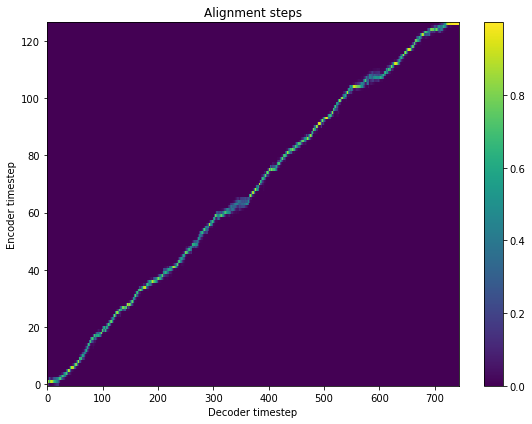

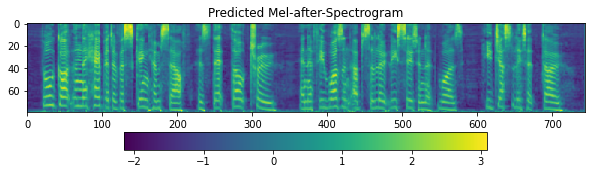

In [ ]:
mels, alignment_history, audios = do_synthesis(input_text, tacotron2, melgan, "TACOTRON", "MELGAN")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=22050)